# Chapter 3: Linear Regression Lab

In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from statsmodels.stats.outliers_influence \
    import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize, poly)

## Simple Linear Regression

We will use a Boston housing data set that records the median house value (medv) for 506 neighborhoods around Boston. We want to predict medv using 13 predictors.

In [2]:
# Load Boston data set 
boston = load_data("Boston")
boston.columns

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'lstat', 'medv'],
      dtype='object')

In [3]:
# lstat - percent of households with low socioeconomic status
X = pd.DataFrame({'intercept': np.ones(boston.shape[0]),
                 'lstat': boston['lstat']})
X.head()

,intercept,lstat
0,1.0,4.98
1,1.0,9.14
2,1.0,4.03
3,1.0,2.94
4,1.0,5.33


In [4]:
# Extract response and fit model 
y = boston['medv']
model = sm.OLS(y, X)
results = model.fit()

Note: sm.OLS() does not fit the model, it specifies the model and then model.fit() does the actual fitting. 

In [5]:
summarize(results)

,coef,std err,t,P>|t|
intercept,34.5538,0.563,61.415,0.0
lstat,-0.9500,0.039,-24.528,0.0


A transform is an object that is created with some parameters and arguments. The object has two main methods: fit() and transform(). ModelSpec() creates a transform object and then fit_transform() is used to construct a corresponding model matrix.

In [6]:
# Create a transform object
design = MS(['lstat'])
X = design.fit_transform(boston)
X.head()

,intercept,lstat
0,1.0,4.98
1,1.0,9.14
2,1.0,4.03
3,1.0,2.94
4,1.0,5.33


In [7]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     601.6
Date:                Thu, 02 Jan 2025   Prob (F-statistic):           5.08e-88
Time:                        13:45:48   Log-Likelihood:                -1641.5
No. Observations:                 506   AIC:                             3287.
Df Residuals:                     504   BIC:                             3295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     34.5538      0.563     61.415      0.000      33.448      35.659
lstat         -0.9500      0.039    -24.528      0.000      -1.026      -0.874
==============================================================================
Omnibus:                      137.043   Durbin-Watson:                   0.892
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              291.373
Skew:                           1.453   Prob(JB):                     5.36e-64
Kurtosis:                       5.319   Cond. No.                         29.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
# Predict medv on new lstat values
new_lstats = pd.DataFrame({'lstat': [5, 10, 15]})
newX = design.transform(new_lstats)
preds = results.get_prediction(newX)

In [9]:
# Predicted values
preds.predicted_mean

array([29.80359411, 25.05334734, 20.30310057])

In [10]:
# Confidence intervals 
preds.conf_int(alpha=0.05)

array([[29.00741194, 30.59977628],
       [24.47413202, 25.63256267],
       [19.73158815, 20.87461299]])

In [11]:
# Prediction intervals
preds.conf_int(obs=True, alpha=0.05)

array([[17.56567478, 42.04151344],
       [12.82762635, 37.27906833],
       [ 8.0777421 , 32.52845905]])

In [12]:
# Add line with slope m and intercept b
def abline(ax, b, m, *args, **kwargs):
    xlim = ax.get_xlim()
    ylim = [m * xlim[0] + b, m * xlim[1] + b]
    ax.plot(xlim, ylim, *args, **kwargs)

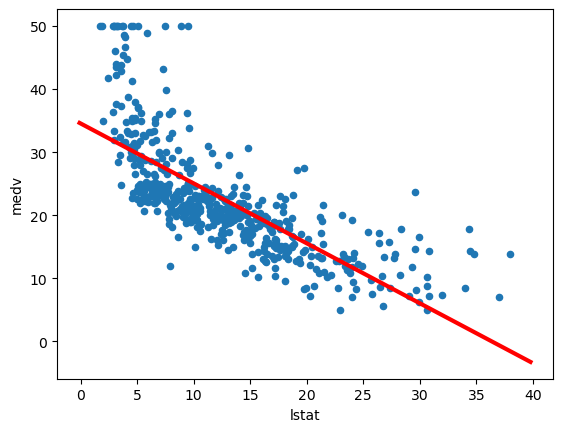

In [13]:
# Add regression line to medv vs. lstat
ax = boston.plot.scatter('lstat', 'medv')
abline(ax,
      results.params.iloc[0],
      results.params.iloc[1],
      'r-',
      linewidth=3)

#### Diagnostic plots 

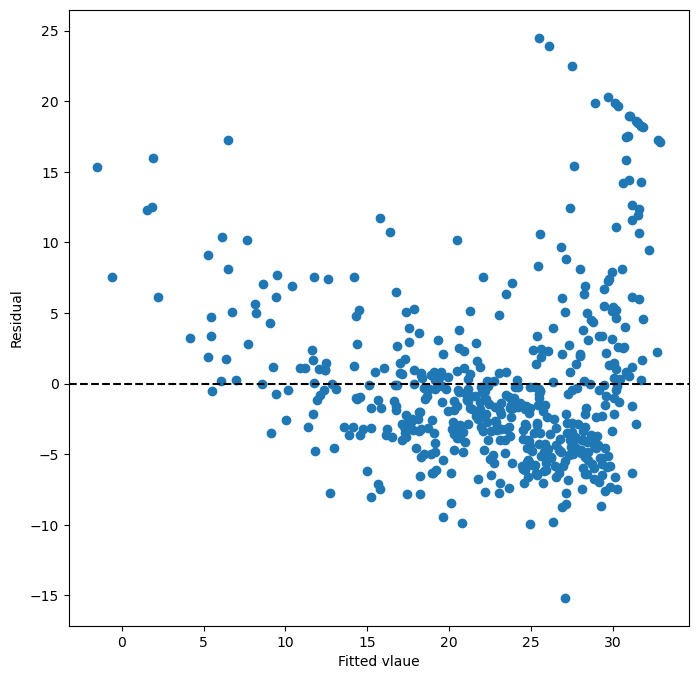

In [14]:
# Residual plot
ax = subplots(figsize=(8,8))[1]
ax.scatter(results.fittedvalues, results.resid)
ax.set_xlabel('Fitted vlaue')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--');

374

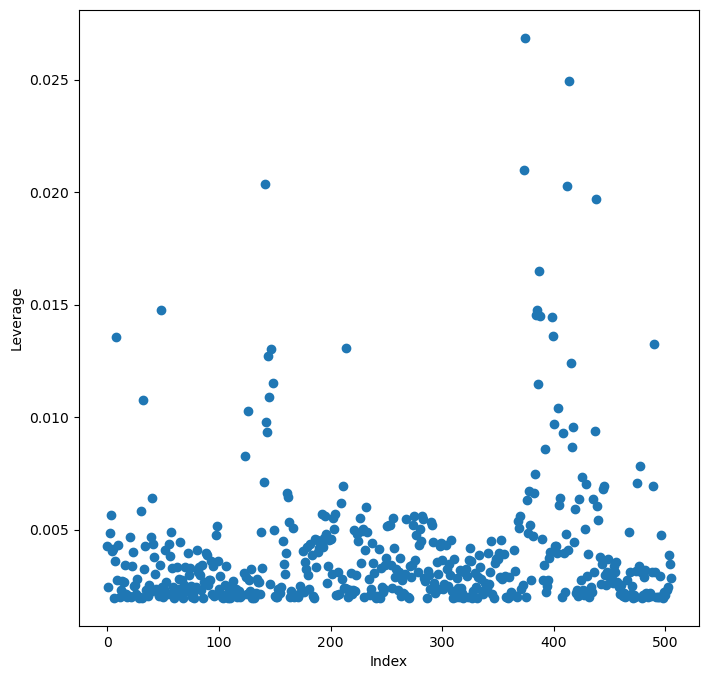

In [15]:
# Leverage plot
infl = results.get_influence()
ax = subplots(figsize=(8,8))[1]
ax.scatter(np.arange(X.shape[0]), infl.hat_matrix_diag)
ax.set_xlabel('Index')
ax.set_ylabel('Leverage')
np.argmax(infl.hat_matrix_diag)

## Multiple Linear Regression

In [16]:
# Regression with lstat and age
X = MS(['lstat', 'age']).fit_transform(boston)
model1 = sm.OLS(y, X)
results1 = model1.fit()
summarize(results1)

,coef,std err,t,P>|t|
intercept,33.2228,0.731,45.458,0.000
lstat,-1.0321,0.048,-21.416,0.000
age,0.0345,0.012,2.826,0.005


In [17]:
# Regression with all predictors
terms = boston.columns.drop('medv')
X = MS(terms).fit_transform(boston)
model2 = sm.OLS(y, X)
results2 = model2.fit()
summarize(results2)

,coef,std err,t,P>|t|
intercept,41.6173,4.936,8.431,0.000
crim,-0.1214,0.033,-3.678,0.000
zn,0.0470,0.014,3.384,0.001
indus,0.0135,0.062,0.217,0.829
chas,2.8400,0.870,3.264,0.001
nox,-18.7580,3.851,-4.870,0.000
rm,3.6581,0.420,8.705,0.000
age,0.0036,0.013,0.271,0.787
dis,-1.4908,0.202,-7.394,0.000
rad,0.2894,0.067,4.325,0.000


In [18]:
# Drop age (high p-value)
sans_age = boston.columns.drop(['medv', 'age'])
Xsa = MS(sans_age).fit_transform(boston)
model3 = sm.OLS(y, Xsa)
summarize(model3.fit())

,coef,std err,t,P>|t|
intercept,41.5251,4.920,8.441,0.000
crim,-0.1214,0.033,-3.683,0.000
zn,0.0465,0.014,3.379,0.001
indus,0.0135,0.062,0.217,0.829
chas,2.8528,0.868,3.287,0.001
nox,-18.4851,3.714,-4.978,0.000
rm,3.6811,0.411,8.951,0.000
dis,-1.5068,0.193,-7.825,0.000
rad,0.2879,0.067,4.322,0.000
tax,-0.0127,0.004,-3.333,0.001


### Multivariate Goodness of Fit

In [19]:
# R-squared
results2.rsquared

0.7343070437613075

In [20]:
# RSE
np.sqrt(results2.scale)

4.798034335596368

In [21]:
# Compute VIFs for each variable
vals = [VIF(X, i) for i in range(1, X.shape[1])]
vif = pd.DataFrame({'vif': vals}, index=X.columns[1:])
vif

,vif
crim,1.767486
zn,2.298459
indus,3.987181
chas,1.071168
nox,4.369093
rm,1.912532
age,3.088232
dis,3.954037
rad,7.445301
tax,9.002158


### Interaction Terms

In [22]:
X = MS(['lstat', 'age', ('lstat', 'age')]).fit_transform(boston)
model4 = sm.OLS(y, X)
summarize(model4.fit())

,coef,std err,t,P>|t|
intercept,36.0885,1.470,24.553,0.000
lstat,-1.3921,0.167,-8.313,0.000
age,-0.0007,0.020,-0.036,0.971
lstat:age,0.0042,0.002,2.244,0.025


### Non-linear Transformations of the Predictors

By default, the poly() function creates a basis matrix for inclusion in the model matrix whose columns are orthogonal polynomials, which are designed for stable least squares computations.

In [23]:
X = MS([poly('lstat', degree=2), 'age']).fit_transform(boston)
model5 = sm.OLS(y, X)
results5 = model5.fit()
summarize(results5)

,coef,std err,t,P>|t|
intercept,17.7151,0.781,22.681,0.0
"poly(lstat, degree=2)[0]",-179.2279,6.733,-26.620,0.0
"poly(lstat, degree=2)[1]",72.9908,5.482,13.315,0.0
age,0.0703,0.011,6.471,0.0


In [24]:
# Compare quadratic and linear fit
anova_lm(results1, results5)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,503.0,19168.128609,0.0,NaN,NaN,NaN
1,502.0,14165.613251,1.0,5002.515357,177.278785,7.468491e-35


Here, the null hypothesis is that the quadratic term in the bigger model is not needed, and the alternative hypothesis is that the bigger model is superior. The F-statistic is 177.28 and the associated p-value is zero. This provides evidence that the quadratic polynomial in lstat improves the linear model. 

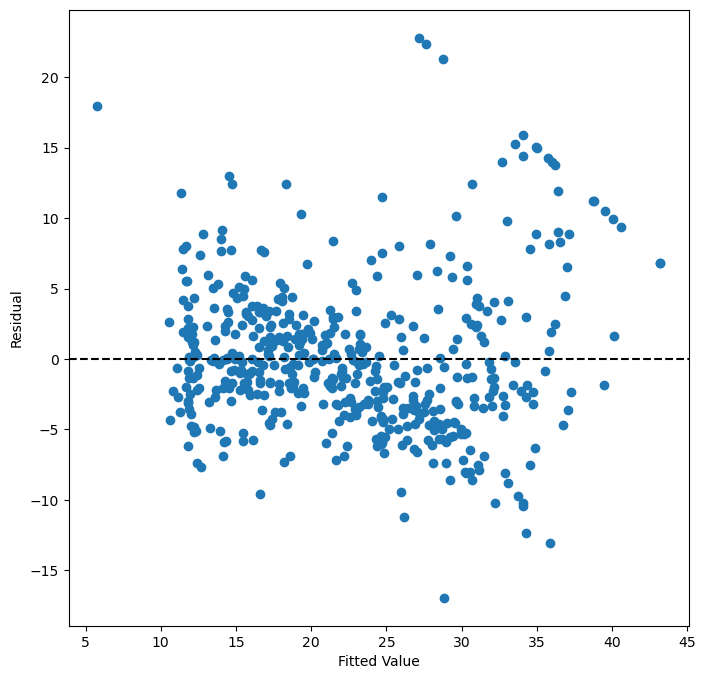

In [25]:
# Residual plot of quadratic model
ax = subplots(figsize=(8,8))[1]
ax.scatter(results5.fittedvalues, results5.resid)
ax.set_xlabel('Fitted Value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--')

We see there is little discernible pattern in the residuals.

## Qualitative Predictors

We will attempt to predict child carseat sales in 400 locations based on a number of predictors.

In [26]:
carseats = load_data('Carseats')
carseats.columns

Index(['Sales', 'CompPrice', 'Income', 'Advertising', 'Population', 'Price',
       'ShelveLoc', 'Age', 'Education', 'Urban', 'US'],
      dtype='object')

In [27]:
allvars = list(carseats.columns.drop('Sales'))
y = carseats['Sales']
final = allvars + [('Income', 'Advertising'), ('Price', 'Age')]
X = MS(final).fit_transform(carseats)
model = sm.OLS(y, X)
summarize(model.fit())

,coef,std err,t,P>|t|
intercept,6.5756,1.009,6.519,0.000
CompPrice,0.0929,0.004,22.567,0.000
Income,0.0109,0.003,4.183,0.000
Advertising,0.0702,0.023,3.107,0.002
Population,0.0002,0.000,0.433,0.665
Price,-0.1008,0.007,-13.549,0.000
ShelveLoc[Good],4.8487,0.153,31.724,0.000
ShelveLoc[Medium],1.9533,0.126,15.531,0.000
Age,-0.0579,0.016,-3.633,0.000
Education,-0.0209,0.020,-1.063,0.288


ModelSpec() generates dummy variables automatically. So, we have ShelveLoc[Good] that takes a value of 1 if the shelving unit is Good and 0 otherwise. Similarly for ShelveLoc[Medium]. A Bad shelving unit is 0 for both dummy variables. 